In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [188]:
class Node:
    def __init__(self, j=None, t=None, is_leaf=False):
        self.j = j
        self.t = t
        self.left = None
        self.right = None
        self.is_leaf = is_leaf
        self.value = None

    def init(self):
        self.left = Node()
        self.right = Node()

    def __str__(self):
        return f"j: {self.j}\nt: {self.t}\nleaf: {self.is_leaf}\nvalue: {self.value}\n"

class DecisionTree():
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.depth = 0
        self.levels = set()
        self.tree = Node()

    def separate_node(self, X, y, node, level):
        j = 0
        t = 0
        max_gain = 0.0
        for feature_ind in range(X.shape[1]):
            max_f = max(X[:, feature_ind])
            min_f = min(X[:, feature_ind])
            for feature_val in X[:, feature_ind]:
                if feature_val in [max_f, min_f]:
                    continue
                ind_l = X[:, feature_ind] <= feature_val
                ind_r = X[:, feature_ind] >  feature_val
                Xl = X[ind_l, :]
                yl = y[ind_l]
                Xr = X[ind_r, :]
                yr = y[ind_r]
                nXr = Xr.shape[0]
                nXl = Xl.shape[0]
                nX = X.shape[0]
                gain = nX * self.impurity(y) - nXr * self.impurity(yr) - nXl * self.impurity(yl)
                if gain > max_gain:
                    max_gain = gain
                    j = feature_ind
                    t = feature_val
        node.init()
        node.j = j
        node.t = t
        self.levels.add(level)
        self.depth = len(self.levels)
        ind_l = X[:, j] <= t
        ind_r = X[:, j] >  t
        if self.depth < self.max_depth and sum(ind_l) != 0 and sum(ind_r) != 0:
            Xl = X[ind_l, :]
            yl = y[ind_l]
            Xr = X[ind_r, :]
            yr = y[ind_r]
            self.separate_node(Xl, yl, node.left, level + 1)
            self.separate_node(Xr, yr, node.right, level + 1)
        else:
            node.is_leaf = True
            node.value = self.calc_answer(y)

    def fit(self, X, y):
        self.separate_node(X, y, self.tree, 0)

    def transform_vec(self, vec):
        node = self.tree
        while not node.is_leaf:
            j, t = node.j, node.t
            move = "left" if vec[j] <= t else "right"
            node = node.left if move == "left" else node.right
        return node.value
            
        
    def predict(self, X):
        return np.apply_along_axis(self.transform_vec, 1, X)
        

In [189]:
class DecisionTreeRegressor(DecisionTree):
    def __init__(self, max_depth=5, impurity="mse"):
        super().__init__(max_depth)
        if impurity == "mse":
            self.impurity = self.impurity_mse
            self.calc_answer = self.calc_answer_mse
        if impurity == "mae":
            self.impurity = self.impurity_mae
            self.calc_answer = self.calc_answer_mae
        else:
            raise ValueError

    
    def impurity_mse(self, y):
        return np.std(y) ** 2

    
    def calc_answer_mse(self, y):
        return np.mean(y)

    
    def impurity_mae(self, y):
        return np.mean(np.abs(y - np.median(y)))

    
    def calc_answer_mae(self, y):
        return np.median(y)
        

In [154]:
from sklearn.base import ClassifierMixin
import math

class DecisionTreeClassifier(ClassifierMixin):
    def __init__(self, max_depth=5, impurity="entropy"):
        self.max_depth = max_depth
        if impurity == "entropy":
            self.impurity = self.impurity_entropy
        if impurity == "gini":
            self.impurity = self.impurity_gini
        self.calc_answer = self.calc_max_probas
        self.depth = 0
        self.levels = set()
        self.tree = Node()
        self.classes = None

    def calc_probas(self, y):
        probas = []
        num_objs = y.shape[0]
        for cl in self.classes:
            probas.append(np.sum(y == cl) / num_objs)
        return probas

    def calc_max_probas(self, y):
        probas = self.calc_probas(y)
        return self.classes[np.argmax(np.array(probas))]
        
    def impurity_entropy(self, X, y):
        probas = self.calc_probas(y)
        imp = 0.0
        for p in probas:
            imp -= 0 if p == 0 else p * math.log(p)
        return imp

    def impurity_gini(self, X, y):
        probas = self.calc_probas(y)
        imp = 1.0
        for p in probas:
            imp -= p ** 2
        return imp
        
    def separate_node(self, X, y, node, level):
        j = 0
        t = 0
        max_gain = 0.0
        for feature_ind in range(X.shape[1]):
            max_f = max(X[:, feature_ind])
            min_f = min(X[:, feature_ind])
            for feature_val in X[:, feature_ind]:
                if feature_val in [max_f, min_f]:
                    continue
                ind_l = X[:, feature_ind] <= feature_val
                ind_r = X[:, feature_ind] >  feature_val
                Xl = X[ind_l, :]
                yl = y[ind_l]
                Xr = X[ind_r, :]
                yr = y[ind_r]
                nXr = Xr.shape[0]
                nXl = Xl.shape[0]
                nX = X.shape[0]
                gain = nX * self.impurity(X, y) - nXr * self.impurity(Xr, yr) - nXl * self.impurity(Xl, yl)
                if gain > max_gain:
                    max_gain = gain
                    j = feature_ind
                    t = feature_val
        node.init()
        node.j = j
        node.t = t
        self.levels.add(level)
        self.depth = len(self.levels)
        ind_l = X[:, j] <= t
        ind_r = X[:, j] >  t
        if self.depth < self.max_depth and sum(ind_l) != 0 and sum(ind_r) != 0:
            Xl = X[ind_l, :]
            yl = y[ind_l]
            Xr = X[ind_r, :]
            yr = y[ind_r]
            self.separate_node(Xl, yl, node.left, level + 1)
            self.separate_node(Xr, yr, node.right, level + 1)
        else:
            node.is_leaf = True
            node.value = self.calc_answer(y)

    def fit(self, X, y):
        self.classes = list(set(y))
        self.separate_node(X, y, self.tree, 0)

    def transform_vec(self, vec):
        node = self.tree
        while not node.is_leaf:
            j, t = node.j, node.t
            # print(j, t)
            move = "left" if vec[j] <= t else "right"
            node = node.left if move == "left" else node.right
        return node.value
            
        
    def predict(self, X):
        return np.apply_along_axis(self.transform_vec, 1, X)
        

In [190]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))


(500, 1)
(500,)


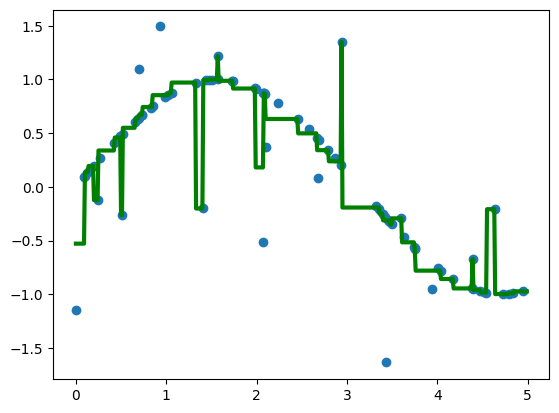

In [196]:
reg = DecisionTreeRegressor(max_depth=50, impurity="mae")
reg.fit(X, y)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
print(X_test.shape)
y_test = reg.predict(X_test)
print(y_test.shape)

plt.scatter(X, y)
plt.plot(X_test, y_test, color="green", linewidth=3)


X.shape: (100, 2), y.shape: (100,)


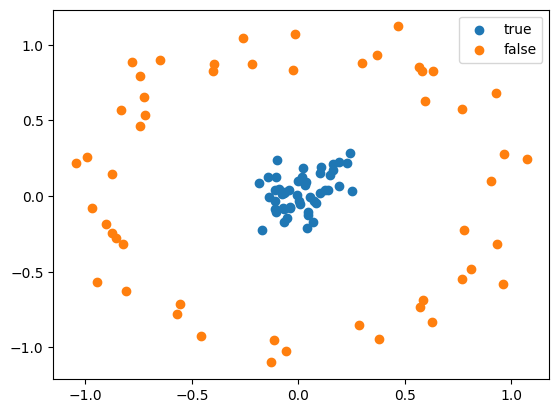

In [158]:
from sklearn.datasets import make_circles

X, y = make_circles(150, factor=0.1, noise=0.1, random_state=42)

X_test, y_test = X[100:], y[100:]
X, y = X[:100], y[:100]

print(f"X.shape: {X.shape}, y.shape: {y.shape}")

plt.scatter(X[y == 1, 0], X[y == 1, 1], label="true")
plt.scatter(X[y == 0, 0], X[y == 0, 1], label="false")
plt.legend()

In [182]:
from sklearn.metrics import accuracy_score

y[y==0] = -1
y_test[y_test==0] = -1

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X_test, y_test)
pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, pred))

Accuracy:  0.92


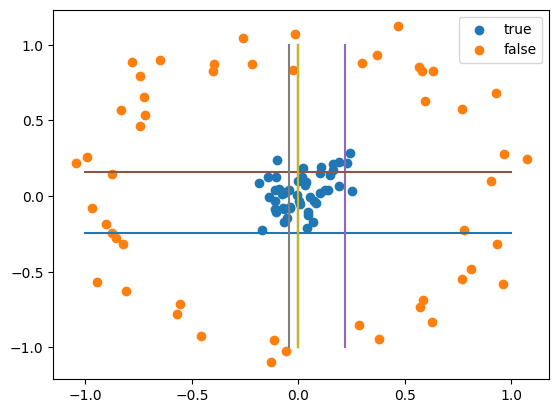

In [183]:
def plt_node(node):
    feat = "x" if node.j == 0 else "y"
    if feat == "x":
        plt.plot([node.t, node.t], [-1, 1])
    else:
        plt.plot([-1, 1], [node.t, node.t])
    node
    if node.is_leaf:
        return 
    plt_node(node.left)
    plt_node(node.right)

plt_node(clf.tree)   

plt.scatter(X[y == 1, 0], X[y == 1, 1], label="true")
plt.scatter(X[y == -1, 0], X[y == -1, 1], label="false")
plt.legend()

In [187]:
class A:
    def __init__(self):
        # self.print = self.print_1
        pass

    def print_1(self):
        print("Class A1")

    def print_2(self):
        print("Class A2")

    def do(self):
        self.print()

class B(A):
    def __init__(self):
        super().__init__()
        self.print = self.print_3

    def print_3(self):
        print("Class B3")

b = B()
b.do()

Class B3
